In [324]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio

import pandas as pd
import librosa
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, random_split,Dataset
import librosa.display
import matplotlib.pyplot as plt
import tarfile


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder

from datetime import datetime
import shutil
import random
import os
import pathlib


In [325]:
import IPython.display as ipd

from tqdm import tqdm

In [326]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## load data


In [327]:
dataSetPath = '../processed_audio_files_nn/'
#dataSetPath = 'processed_audio_files/'
disease_labels = ["Asthma","COPD","Bronchiectasis","Pneumonia","URTI","Healthy","Bronchiolitis","LRTI"]
target_conditions = ["COPD","Healthy"]

In [328]:
def getFilenameInfo(file):
    return file.split('_')

In [329]:
def plotDataSet(dataSetPath , disease_labels):
  '''plots the data-set's ingredients, and returns a dictionary with the results'''
  audio_data_dir = dataSetPath + "*.wav"
  filenames = os.listdir(dataSetPath)
  dataCountList = [0 for i in range(len(disease_labels))]
  for filename in filenames:
    dataCountList[disease_labels.index(getFilenameInfo(filename)[0])] += 1

  # print(dataCountList,dataCountList)

  plt.bar(disease_labels,dataCountList)
  plt.xticks(rotation=90)
  dataSetInfo = {disease_labels[i] : dataCountList[i] for i in  range(len(dataCountList))}    #dictionary with data set consistancy
  return dataSetInfo

{'Asthma': 6,
 'COPD': 5746,
 'Bronchiectasis': 104,
 'Pneumonia': 285,
 'URTI': 243,
 'Healthy': 322,
 'Bronchiolitis': 160,
 'LRTI': 32}

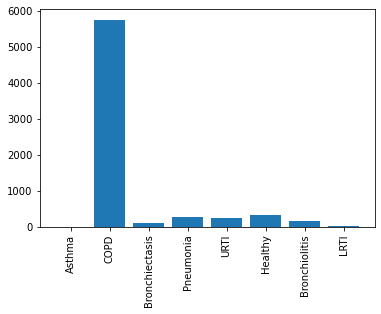

In [330]:
plotDataSet(dataSetPath , disease_labels)

In [331]:
def copy_targetConditions(targets = [], destination = 'target_conditions/',source = 'balanced_dataset/'):
    '''copy the files with names in target conditions list to the destination location'''
    files = os.listdir(source)
    if not os.path.exists(destination):
        os.makedirs(destination)
    for file in files:
        if (getFilenameInfo(file)[0] in targets):
            # print(getFilenameInfo(file)[0])
            shutil.copy(source + file , destination)
            

In [332]:
#copy_targetConditions(targets = target_conditions, destination = 'target_conditions/',source = 'balanced_dataset/')

{'COPD': 792, 'Healthy': 770}

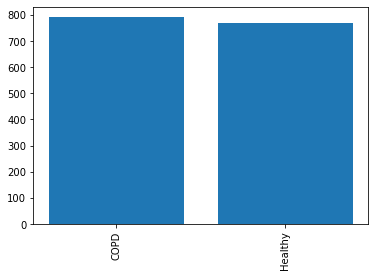

In [333]:
plotDataSet('../target_conditions/' , target_conditions)

In [334]:
from pathlib import Path
dataSetPathS = '../target_conditions/'
dataSetPath = Path('../target_conditions/')

files = os.listdir(dataSetPath)
# shuffle the data
random.shuffle(files)

labels = np.array([getFilenameInfo(file)[0] for file in files])
# print (str(labels[:10]) + 'files : ' + str(files[:10]))

# print(files)


In [335]:
print (labels[0])
print (files[0])



COPD
COPD_146_8p3_Pl_mc_AKGC417L_copy_1.wav


In [336]:
# dataset_path = "..\Datasets\Dataset1\Respiratory_Sound_Database\Respiratory_Sound_Database"
# csv_path = dataset_path + "\patient_diagnosis.csv"
# file_path = dataset_path + "\audio_and_txt_files"

In [337]:
# patient_data = pd.read_csv(csv_path,names=['Patient number', 'Diagnosis'])
# print (patient_data.head)

In [338]:


import IPython
def display_wav(list_id):
    patient_sounds = list(dataSetPath.glob(f'{files[list_id]}'))
    test_wav = librosa.core.load(patient_sounds[0], sr=16000)[0]

    fig, ax = plt.subplots(2, 1, figsize=(20,5))
    ax[0].plot(test_wav)
    ax[0].set_title(f"Full {files[list_id]} waveform")

    mel = librosa.feature.melspectrogram(test_wav, sr=16000, n_fft=512, hop_length=256, win_length=512, window='hann', n_mels=100)
    mel[mel < 1e-12] = 1e-12
    ax[1].imshow(np.log(mel)[:,:1000], origin='lower')
    ax[1].set_title(f"Slice of {files[list_id]} mel spectrogram 512 fft")

C:\Users\iresh\AppData\Local\Temp\ipykernel_7408\2321289977.py:10: FutureWarning: Pass y=[0.         0.         0.         ... 0.00366211 0.00360107 0.00354004] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(test_wav, sr=16000, n_fft=512, hop_length=256, win_length=512, window='hann', n_mels=100)


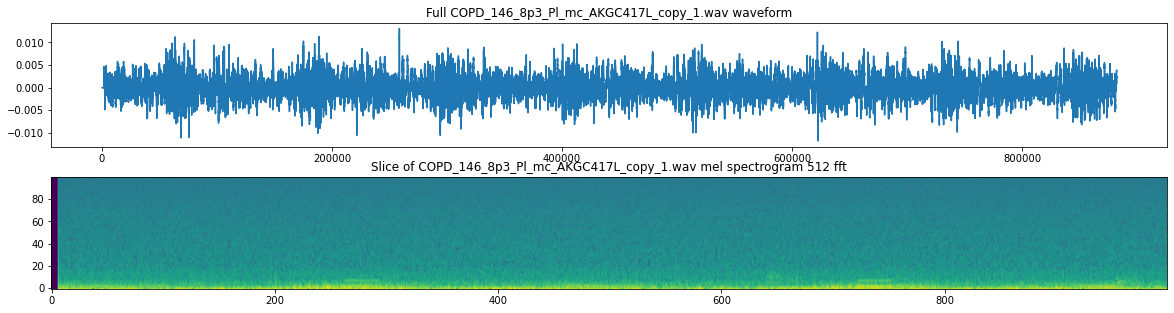

In [339]:
display_wav(0)

In [340]:
SAMPLE_WAV_SPEECH_PATH = dataSetPathS + files[0]

metadata = torchaudio.info(dataSetPathS + files[0])
print(metadata)    
# for i in range(0,len(files)):
#     waveform,sr = torchaudio.load(dataSetPathS + files[i])
#     # print(metadata) 
#     if (waveform.numel() !=882000):
#         print (waveform.numel())


waveform, sample_rate = torchaudio.load(SAMPLE_WAV_SPEECH_PATH)
print (waveform.numel())
     

AudioMetaData(sample_rate=16000, num_frames=882000, num_channels=1, bits_per_sample=16, encoding=PCM_S)
882000


In [341]:
le = LabelEncoder()
i_labels = le.fit_transform(labels)

# print(i_labels)
oneHotLabels = F.one_hot(torch.from_numpy(i_labels))
# print(oneHotLabels)
# print(oneHotLabels[:10])

features = np.array(files)


#split the data set

x_train,x_test,y_train,y_test = train_test_split(features,oneHotLabels,stratify=oneHotLabels,test_size=0.1,random_state = 42)
x_test,x_val,y_test,y_val = train_test_split(features,oneHotLabels,stratify=oneHotLabels,test_size=0.2,random_state = 42)


In [342]:
print(len(x_test))

1249


In [343]:
class LungSoundDataSet(Dataset):
    def __init__(self,files,labels, file_path):
        self.files = files
        self.lables = labels
        self.file_path = file_path
        
    def __getitem__(self,index):
        path = self.file_path  + self.files[index]
        soundd  = torchaudio.load(path)
        #load returns a tensor with the sound data and the sampling frequency 
        sound = soundd[0]
        tempData = torch.zeros([882000])
        #to zero pad shorter sound files
        if sound.numel() < 882000:
            tempData [:sound.numel()] = sound[:]

        elif (sound.numel() >= 882000):
            tempData[:] = sound[:882000]
        sound = tempData
        downSamSound = sound[::27]          #to be chaged
        # print (downSamSound.numel())
        return downSamSound,self.lables[index]
    def __len__(self):
        return len(self.files)

train_set = LungSoundDataSet(files[:-100],labels[:-100],dataSetPathS)
test_set = LungSoundDataSet(files[-100:],labels[-100:],dataSetPathS)
# print (train_set.__getitem__(1))
# print(files[1])
print("Train set size: " + str(len(train_set)))
print("Test set size: " + str(len(test_set)))

kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {} #needed for using datasets on gpu

train_loader = torch.utils.data.DataLoader(train_set, batch_size = 128, shuffle = True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 128, shuffle = True, **kwargs)

Train set size: 1462
Test set size: 100


In [344]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(1, 128, 80, 4)
        self.bn1 = nn.BatchNorm1d(128)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(128, 128, 3)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(128, 256, 3)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(256, 512, 3)
        self.bn4 = nn.BatchNorm1d(512)
        self.pool4 = nn.MaxPool1d(4)
        self.avgPool = nn.AvgPool1d(30) #input should be 512x30 so this outputs a 512x1
        self.fc1 = nn.Linear(512, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = self.avgPool(x)
        x = x.permute(0, 2, 1) #change the 512x1 to 1x512
        x = self.fc1(x)
        return F.log_softmax(x, dim = 2)

model = Net()
model.to(device)
print(model)

Net(
  (conv1): Conv1d(1, 128, kernel_size=(80,), stride=(4,))
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(256, 512, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (avgPool): AvgPool1d(kernel_size=(30,), stride=(30,), 

In [345]:
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 20, gamma = 0.1)
optimizer = optim.Adam(model.parameters(), lr = 0.01, weight_decay = 0.0001)


In [346]:

def train(model, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        data = data.requires_grad_() #set requires_grad to True for training
        output = model(data)
        output = output.permute(1, 0, 2) #original output dimensions are batchSizex1x10 
        loss = F.nll_loss(output[0], target) #the loss functions expects a batchSizex10 input
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0: #print training stats
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss))

In [354]:
def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        output = output.permute(1, 0, 2)
        pred = output.max(2)[1] # get the index of the max log-probability
        correct += pred.eq(target).cpu().sum().item()
    print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [355]:
log_interval = 20
for epoch in range(1, 41):
    if epoch == 31:
        print("First round of training complete. Setting learn rate to 0.001.")
    scheduler.step()
    train(model, epoch)
    test(model, epoch)